In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

dataset = pd.read_csv("MH_precrocessed_dataset.csv")
dataset.drop(columns=["Address", "SellerG", "Date", "Propertycount", "Postcode"], inplace=True)

# Log(x+1) transformation
dataset['LogPrice'] = np.log1p(dataset['Price'])

# Creating Price Categories (Low, Mid, High)
dataset['PriceCategory'] = pd.qcut(dataset['LogPrice'], q=3, labels=["Low", "Mid", "High"])

# Label encoding (hedef değişken)
label_encoder = LabelEncoder()
dataset['PriceCategoryEncoded'] = label_encoder.fit_transform(dataset['PriceCategory'])

# separating features and target 
X = dataset.drop(columns=["Price", "LogPrice", "PriceCategory", "PriceCategoryEncoded"])
y = dataset["PriceCategoryEncoded"]

# separation of numeric and categoric columns
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Preprocessing Pipeline: numeric = scaler, categoric  = one hot
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])


In [77]:
# Calculate the original price ranges from the log-transformed bins
log_bins = pd.qcut(dataset['LogPrice'], q=3, retbins=True)[1]
price_bins_original = np.expm1(log_bins).round(2)

# Create a grouped summary table with relevant aggregated features
summary_table = dataset.groupby("PriceCategory", observed=False).agg({
    "Price": ["count", "min", "max", "mean"],
    "Rooms": "mean",
    "Bedroom2": "mean",
    "Bathroom": "mean",
    "BuildingArea": "mean",
    "Landsize": "mean",
    "Distance": "mean",
    "Type": lambda x: x.mode()[0],
    "Regionname": lambda x: x.mode()[0],
})

# Flatten the multi-level column index
summary_table.columns = [
    "Count", "MinPrice", "MaxPrice", "AvgPrice",
    "AvgRooms", "AvgBedrooms", "AvgBathrooms", 
    "AvgBuildingArea", "AvgLandsize", "AvgDistance",
    "MostCommonType", "MostCommonRegion"
]

# Reset index to keep 'PriceCategory' as a column
summary_table = summary_table.reset_index()

# Generate readable price ranges from original scale
summary_table["PriceRange"] = [
    f"{int(price_bins_original[i]):,} - {int(price_bins_original[i+1]):,}".replace(",", ".")
    for i in range(len(price_bins_original) - 1)
]

# Format price values for readability (e.g., ₺850.000)
summary_table["AvgPrice"] = summary_table["AvgPrice"].apply(lambda x: f"{int(x):,}".replace(",", "."))
summary_table["MinPrice"] = summary_table["MinPrice"].apply(lambda x: f"{int(x):,}".replace(",", "."))
summary_table["MaxPrice"] = summary_table["MaxPrice"].apply(lambda x: f"{int(x):,}".replace(",", "."))

# Rearrange columns for a clearer view
summary_table = summary_table[[
    "PriceCategory", "Count", "PriceRange", "AvgPrice",
    "AvgRooms", "AvgBedrooms", "AvgBathrooms", "AvgBuildingArea", 
    "AvgLandsize", "AvgDistance", "MostCommonType", "MostCommonRegion"
]]

# Display the final summary table
print(summary_table)




  PriceCategory  Count             PriceRange   AvgPrice  AvgRooms  \
0           Low    709      112.000 - 763.562    594.037  2.438646   
1           Mid    633    763.562 - 1.200.000    971.315  3.069510   
2          High    658  1.200.000 - 5.200.000  1.738.934  3.712766   

   AvgBedrooms  AvgBathrooms  AvgBuildingArea  AvgLandsize  AvgDistance  \
0     2.668547      1.231312       114.334274   601.778561    12.202821   
1     3.086888      1.453397       147.472354   594.537125    11.916904   
2     3.574468      1.854103       205.139818   666.496960     9.576292   

  MostCommonType       MostCommonRegion  
0              u  Northern Metropolitan  
1              h  Southern Metropolitan  
2              h  Southern Metropolitan  


In [69]:
from sklearn.utils import resample

df = pd.concat([X, y], axis=1)
df.columns = list(X.columns) + ['target']

# Checking sample sizes
print(df['target'].value_counts())

# Taking minimum class size
min_class_size = df['target'].value_counts().min()

# downsampling
balanced_df = pd.concat([
    resample(df[df['target'] == label], replace=False, n_samples=min_class_size, random_state=42)
    for label in df['target'].unique()
])

# Shuffle after concat
balanced_df = balanced_df.sample(frac=1, random_state=5006).reset_index(drop=True)

# separation of X and y
X_balanced = balanced_df.drop(columns=['target'])
y_balanced = balanced_df['target']

print(y_balanced.value_counts())


target
1    709
0    658
2    633
Name: count, dtype: int64
target
1    633
0    633
2    633
Name: count, dtype: int64


In [83]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Train/Test separation
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# models for classification
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=5006),
    "KNN Classifier": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=5006),
    "Random Forest": RandomForestClassifier(random_state=5006)
}

# Preprocessing pipeline + model loop
for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    
    print(f"\n{name} Test Performance")
    print(classification_report(y_test, y_pred, digits=2))



Logistic Regression Test Performance
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       126
           1       0.75      0.74      0.74       127
           2       0.58      0.60      0.59       127

    accuracy                           0.70       380
   macro avg       0.70      0.70      0.70       380
weighted avg       0.70      0.70      0.70       380


KNN Classifier Test Performance
              precision    recall  f1-score   support

           0       0.69      0.76      0.72       126
           1       0.70      0.69      0.70       127
           2       0.53      0.48      0.50       127

    accuracy                           0.64       380
   macro avg       0.64      0.65      0.64       380
weighted avg       0.64      0.64      0.64       380


Decision Tree Test Performance
              precision    recall  f1-score   support

           0       0.74      0.71      0.73       126
           1       0.74   

In [70]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=5006)

# Logistic Regression CV
logreg_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=5006))
])
logreg_scores = cross_val_score(logreg_pipeline, X_balanced, y_balanced, cv=cv, scoring='accuracy')
print("\n● Logistic Regression 10-Fold CV Accuracy Scores:", np.round(logreg_scores, 3))
print("Average Accuracy:", round(np.mean(logreg_scores), 4))

# Random Forest CV
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=5006))
])
rf_scores = cross_val_score(rf_pipeline, X_balanced, y_balanced, cv=cv, scoring='accuracy')
print("\n● Random Forest 10-Fold CV Accuracy Scores:", np.round(rf_scores, 3))
print("Average Accuracy:", round(np.mean(rf_scores), 4))



● Logistic Regression 10-Fold CV Accuracy Scores: [0.695 0.695 0.763 0.711 0.716 0.642 0.705 0.716 0.695 0.646]
Average Accuracy: 0.6982

● Random Forest 10-Fold CV Accuracy Scores: [0.663 0.7   0.779 0.763 0.726 0.695 0.726 0.716 0.747 0.677]
Average Accuracy: 0.7193


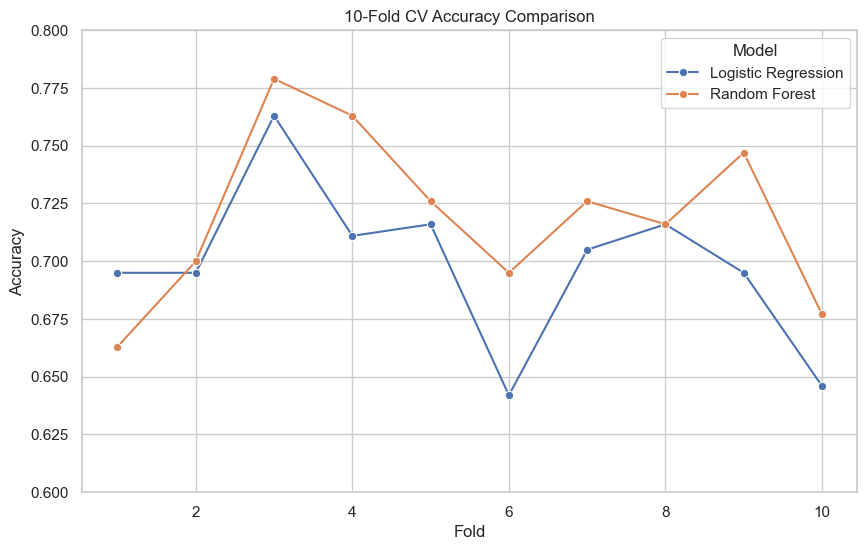

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Örnek veri (sen kendi skorlarını koy)
log_reg_scores = [0.695, 0.695, 0.763, 0.711, 0.716, 0.642, 0.705, 0.716, 0.695, 0.646]
rf_scores = [0.663, 0.7, 0.779, 0.763, 0.726, 0.695, 0.726, 0.716, 0.747, 0.677]

df = pd.DataFrame({
    'Fold': list(range(1, 11)) * 2,
    'Accuracy': log_reg_scores + rf_scores,
    'Model': ['Logistic Regression'] * 10 + ['Random Forest'] * 10
})

# Grafik çizimi
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Fold', y='Accuracy', hue='Model', errorbar=None, marker='o')  # ci=None yerine errorbar=None

plt.title("10-Fold CV Accuracy Comparison")
plt.ylim(0.6, 0.8)
plt.grid(True)
plt.show()

